In [1]:
from src.utils import get_matches

import datasets
from collections import Counter
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
import numpy as np
from math import log10



/Users/kldooste/miniconda3/envs/biodex/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load matches
dataset = datasets.load_dataset("FAERS-PubMed/raw_dataset")
matches = get_matches(dataset['train'])
print(len(matches))

Using custom data configuration FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2
Found cached dataset json (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___json/FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
100%|██████████| 1/1 [00:00<00:00, 62.30it/s]


65648


## Study the origin of the articles and reports

In [3]:
def normalize_countries(countries):
    countries = [c for c in countries if c or c != 'None' or c != 'COUNTRY NOT SPECIFIED']
    countries_norm = []
    for c in countries:
        if c == 'England' or c == 'Scotland':
            countries_norm.append('United Kingdom')
        else:
            countries_norm.append(c)
    countries_iso3 = coco.convert(names=countries_norm, to='ISO3', not_found='NULL')
    return countries_iso3

def plot_world_heatmap(countries, title='', log=True):
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_map = world_map.drop(world_map[world_map['name'] == 'Antarctica'].index)

    # countries_iso3 = normalize_countries(countries)
    counts = Counter(countries)

    world_map['occurances'] = world_map['iso_a3'].apply(lambda x: counts[x])
    world_map['occurances_log'] = world_map['occurances'].apply(lambda x: log10(x) if x else 0)

    if log:
        plot = world_map.plot(figsize=(20, 20), edgecolor='white', linewidth=1, column='occurances_log', cmap='viridis', legend=False)
    else:
        plot = world_map.plot(figsize=(20, 20), edgecolor='white', linewidth=1, column='occurances', cmap='viridis', legend=False)

    # remove axes
    plot.set_axis_off()

    # add legend
    cbar = plt.colorbar(plot.collections[0], fraction=0.02)
    cbar.ax.set_ylabel('Log Occurrences' if log else 'Occurrences')
    cbar.ax.get_yaxis().labelpad = 20

    plt.title(title)
    plt.show()

def plot_world_heatmap_ax(ax, countries, log=True, title=''):
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_map = world_map.drop(world_map[world_map['name'] == 'Antarctica'].index)

    # countries_iso3 = normalize_countries(countries)
    counts = Counter(countries)

    world_map['occurances'] = world_map['iso_a3'].apply(lambda x: counts[x])
    world_map['occurances_log'] = world_map['occurances'].apply(lambda x: log10(x) if x else 0)

    if log:
        plot = world_map.plot(ax=ax, figsize=(6, 6), edgecolor='white', linewidth=1, column='occurances_log', cmap='viridis', legend=False)
    else:
        plot = world_map.plot(ax=ax, figsize=(6, 6), edgecolor='white', linewidth=1, column='occurances', cmap='viridis', legend=False)

    # remove axes
    plot.set_axis_off()

    # # add legend
    # cbar = plt.colorbar(plot.collections[0], ax=ax, fraction=0.02)
    # cbar.ax.set_ylabel('Log Occurrences' if log else 'Occurrences')
    # cbar.ax.get_yaxis().labelpad = 20

    # set title
    ax.set_title(title)

    return plot

In [4]:
report_occur = normalize_countries([r.occurcountry for m in matches for r in m.reports])
article_countries = normalize_countries([m.article.country for m in matches])
report_primarysource = normalize_countries([r.primarysourcecountry for m in matches for r in m.reports])
report_reportercountry = normalize_countries([r.primarysource.reportercountry for m in matches for r in m.reports])


None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in r

None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in r

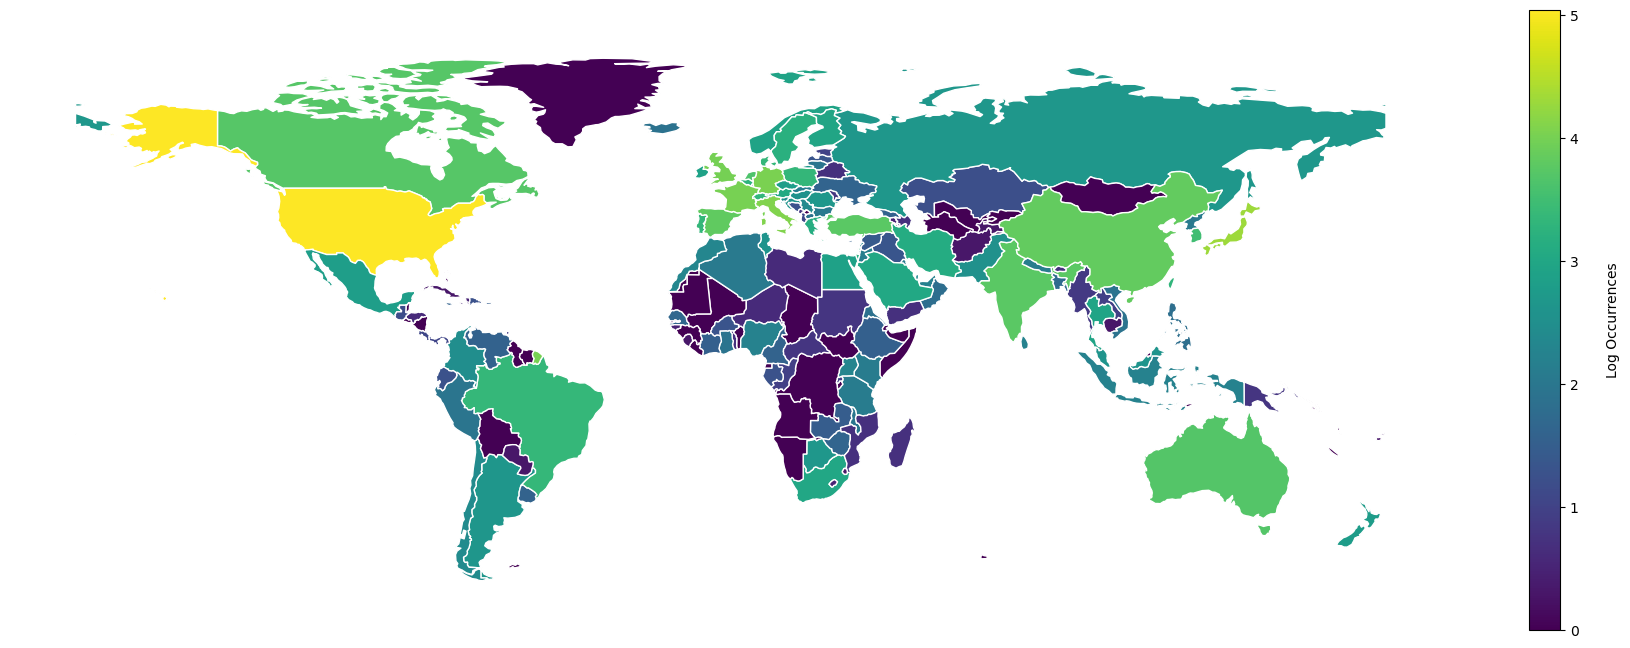

In [ ]:
plot_world_heatmap(report_occur, 'Occurcountry of report')


None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in r

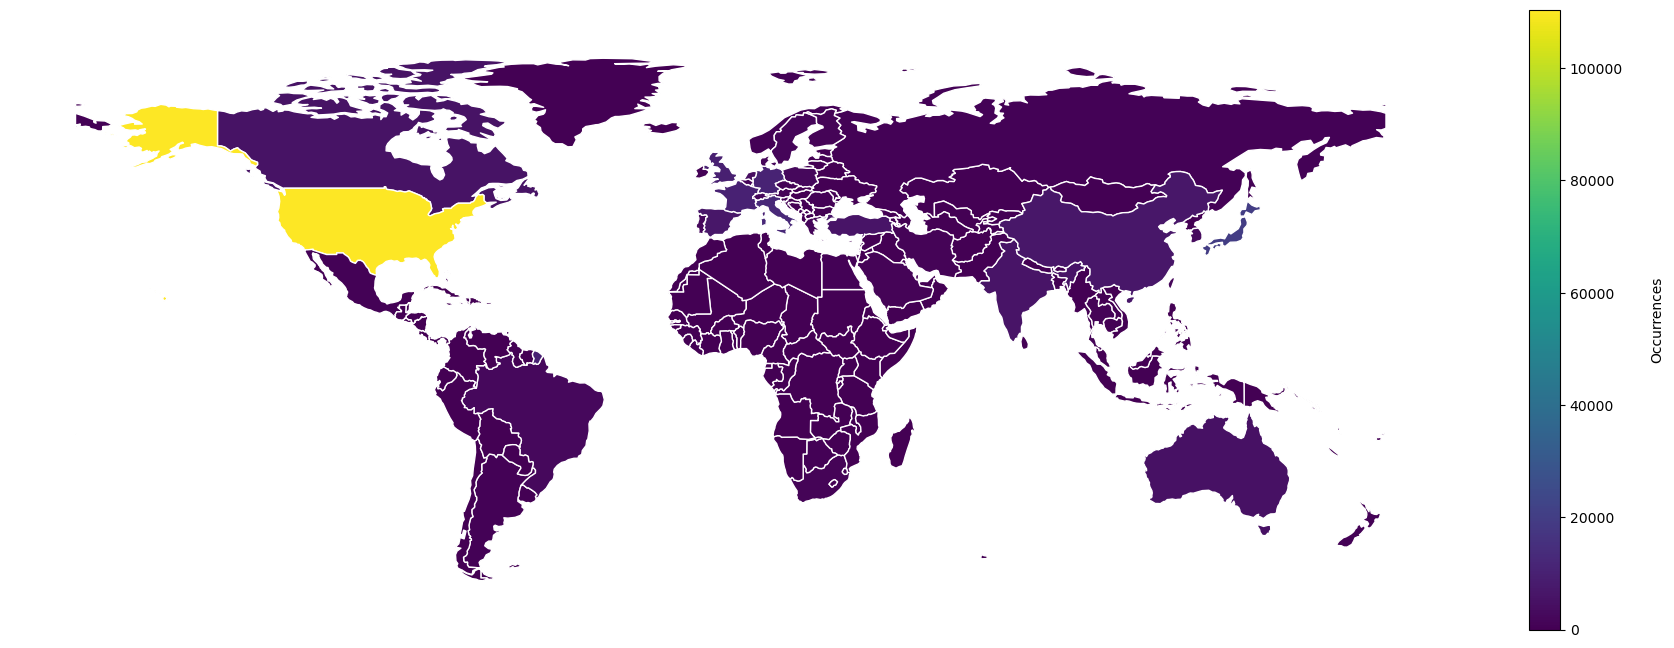

In [ ]:
plot_world_heatmap(report_occur, 'Occurcountry of report', log=False)


None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in r

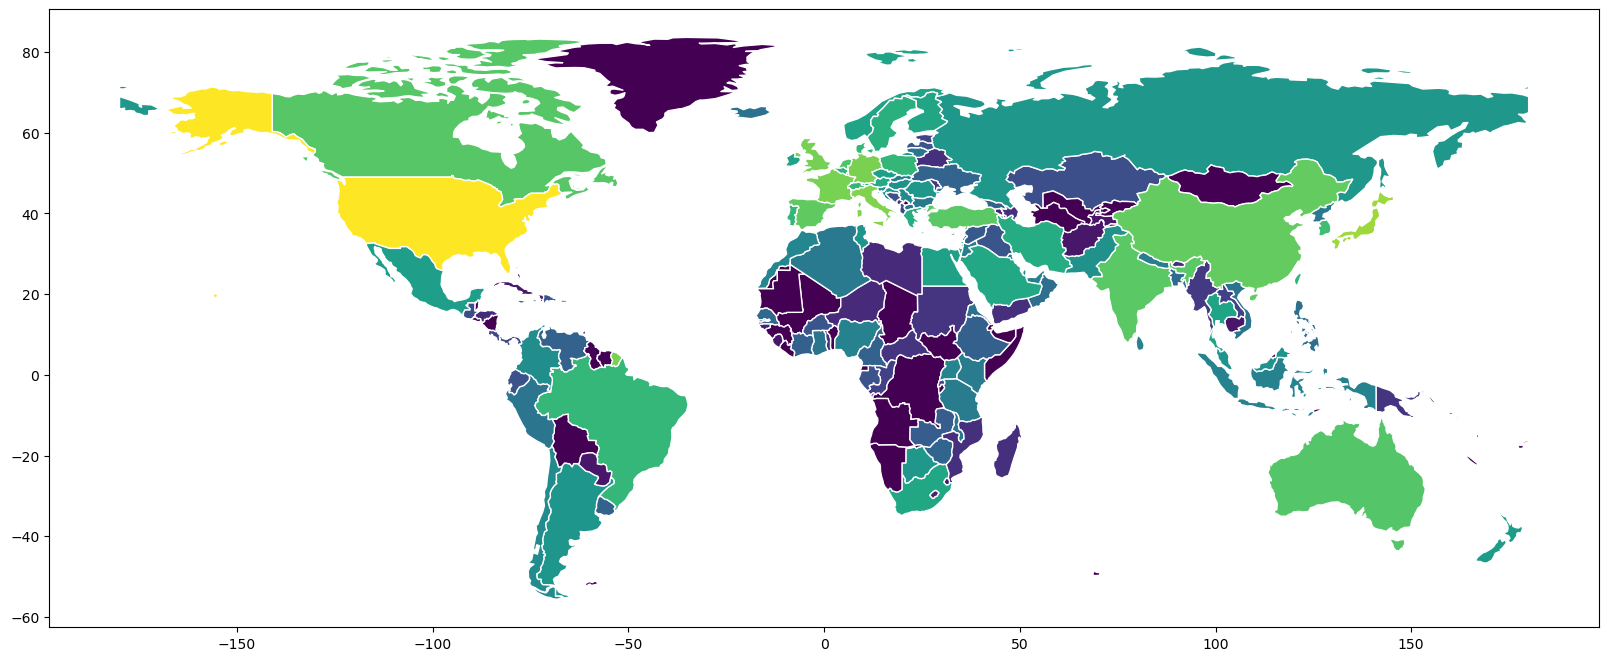

In [ ]:
plot_world_heatmap(article_countries, 'Country of article')

None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in r

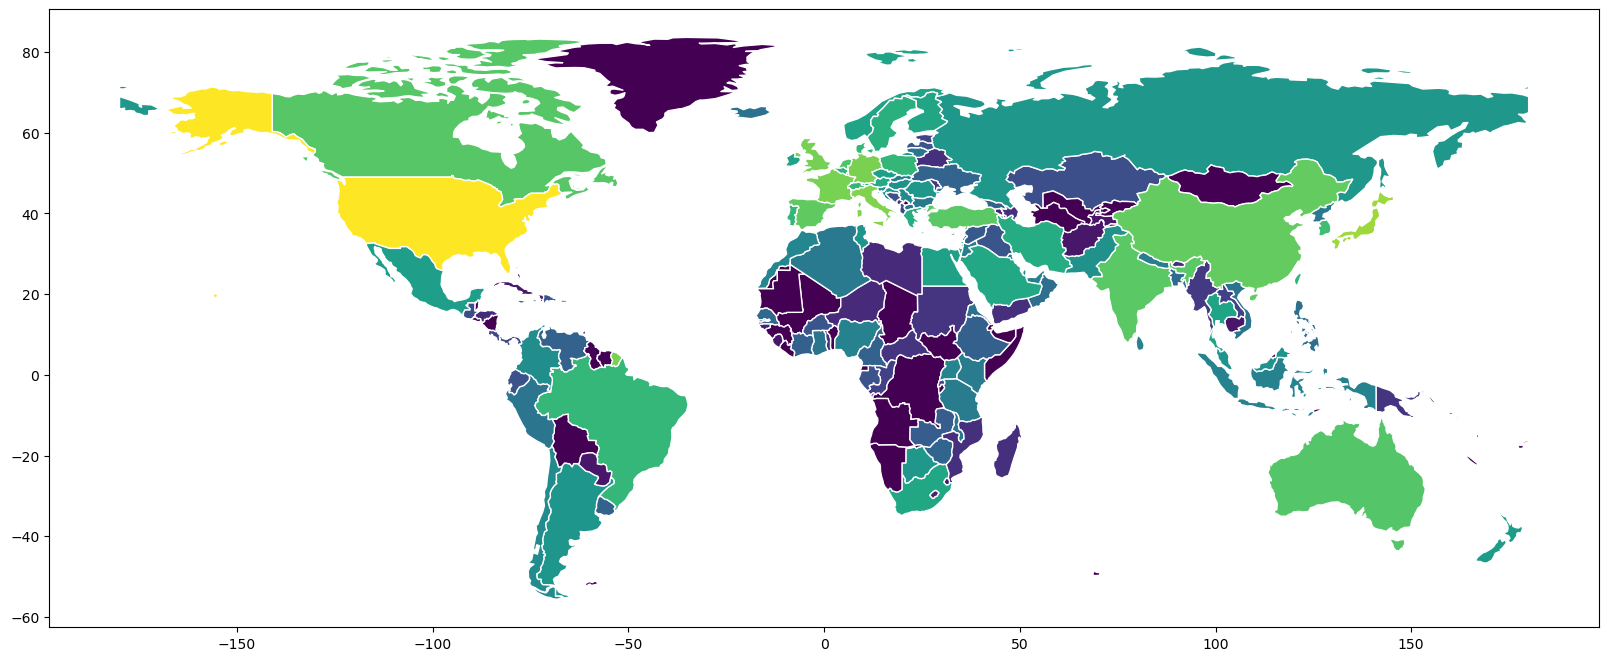

In [ ]:

plot_world_heatmap(report_primarysource,  'Country of report source')

None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in r

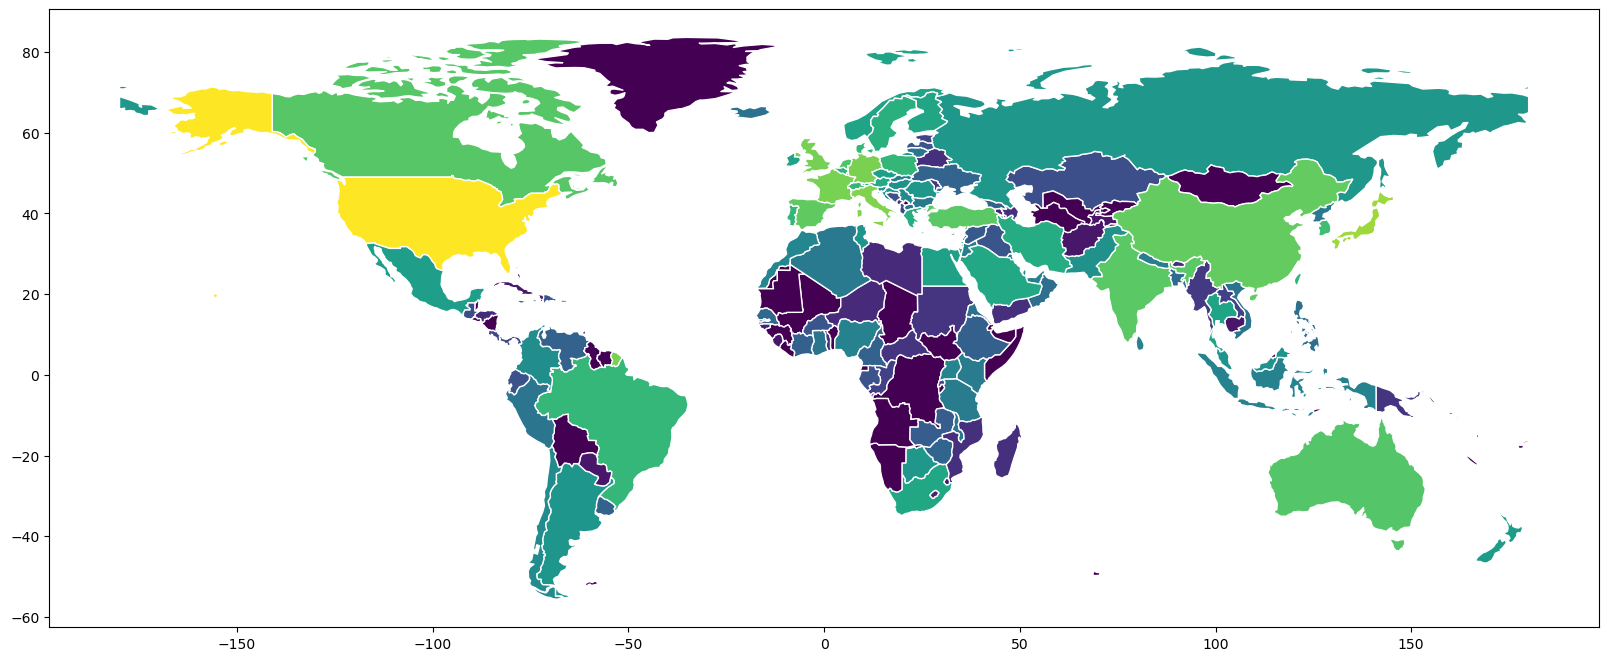

In [ ]:

plot_world_heatmap(report_reportercountry, 'Reporter country')

## Study dates

In [ ]:
from datetime import datetime

article_dates = [m.article.pubdate for m in matches]

report_receive = [r.receivedate for m in matches for r in m.reports]
report_receipt = [r.receiptdate for m in matches for r in m.reports]
report_transmisstion = [r.transmissiondate for m in matches for r in m.reports]

# check how many have the full info
def check_info(s):
    if '-' in s:
        return len(s) == 10
    else:
        return len(s) == 8

# only articles have this problem
print(f'{sum([check_info(s) for s in article_dates])} / {len(article_dates)}')
print(f'{sum([check_info(s) for s in report_receive])} / {len(report_receive)}')
print(f'{sum([check_info(s) for s in report_receipt])} / {len(report_receipt)}')
print(f'{sum([check_info(s) for s in report_transmisstion])} / {len(report_transmisstion)}')

def parse_time_report(ls):
    return [datetime.strptime(s, '%Y%m%d') for s in ls]

def parse_time_article(ls):
    return [datetime.strptime(s[:4], '%Y') for s in ls]

article_dates = parse_time_article(article_dates)
report_receive = parse_time_report(report_receive)
report_receipt = parse_time_report(report_receipt)
report_transmisstion = parse_time_report(report_transmisstion)


14670 / 65648
256240 / 256240
256240 / 256240
256240 / 256240


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def plot_dates_bar(dates, title, article=False):
    # Generate some sample datetimes
    if article:
        start_time = datetime(year=min(dates).year, month=1, day=1)
    else:
        start_time = datetime(year=2001, month=1, day=1)
    end_time = datetime(year=2024, month=1, day=1)


    # Define the bin width (1 month in this case)
    bin_width = relativedelta(years=1)

    # Create a list of year starts
    bin_starts = [datetime(start_time.year, 1, 1)]
    while (end_time - bin_starts[-1]).days > 0:
        bin_starts.append(bin_starts[-1] + bin_width)

    # Create the histogram using the bin edges and datetimes
    hist, bins = np.histogram(dates, bins=bin_starts)

    hist = hist.squeeze()
    hist = list(hist)
    bins = bins.squeeze()
    if article:
        bins = [datetime.strftime(b, '\'%y') for b in bins]
    else:
        bins = [datetime.strftime(b, '%Y') for b in bins]

    # Plot the histogram
    plt.figure(figsize=(10,8))
    plt.bar(bins[:-1], hist)
    plt.xticks(rotation=90)
    plt.xlabel('Time')
    plt.ylabel('Count')
    # plt.yscale('log')
    plt.title(title)
    plt.show()

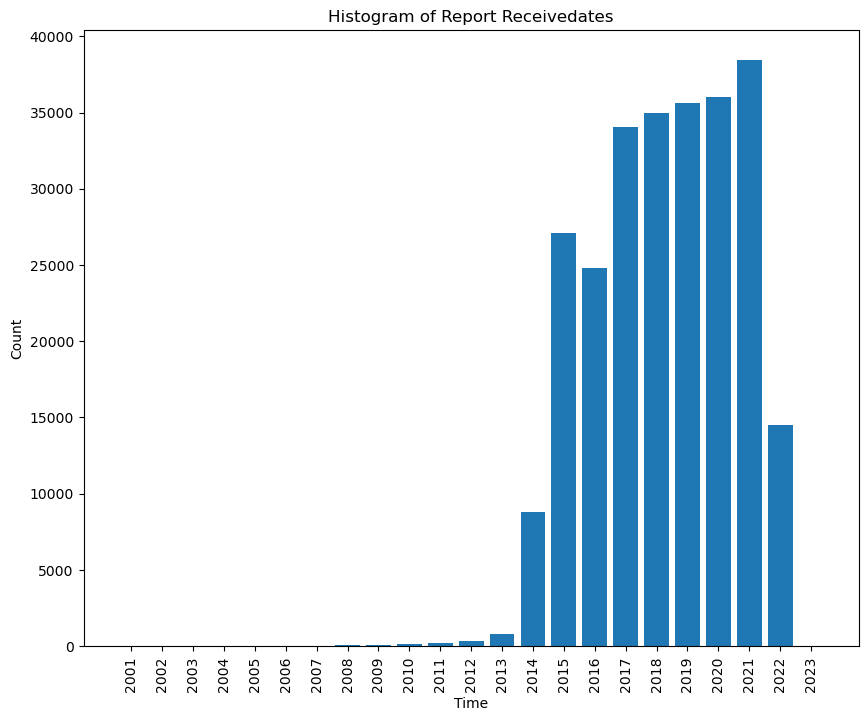

In [ ]:
plot_dates_bar(report_receive, 'Histogram of Report Receivedates')


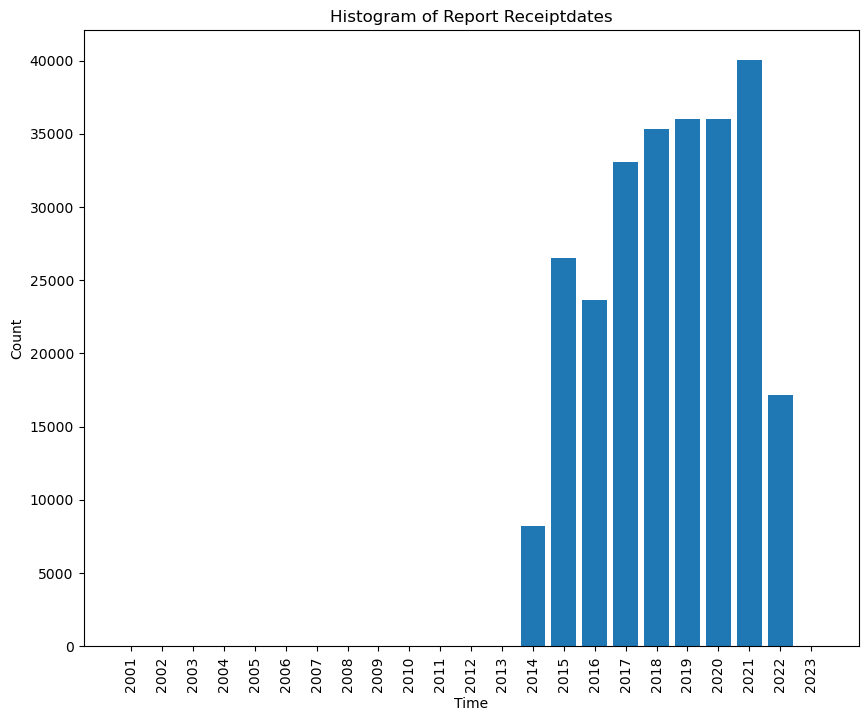

In [ ]:
plot_dates_bar(report_receipt, 'Histogram of Report Receiptdates')


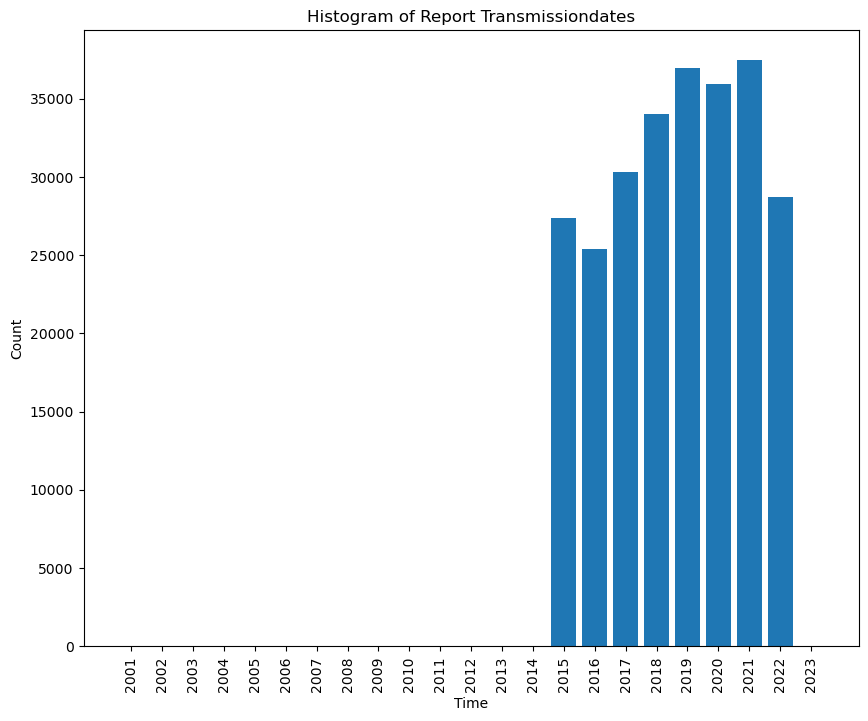

In [ ]:
plot_dates_bar(report_transmisstion, 'Histogram of Report Transmissiondates')


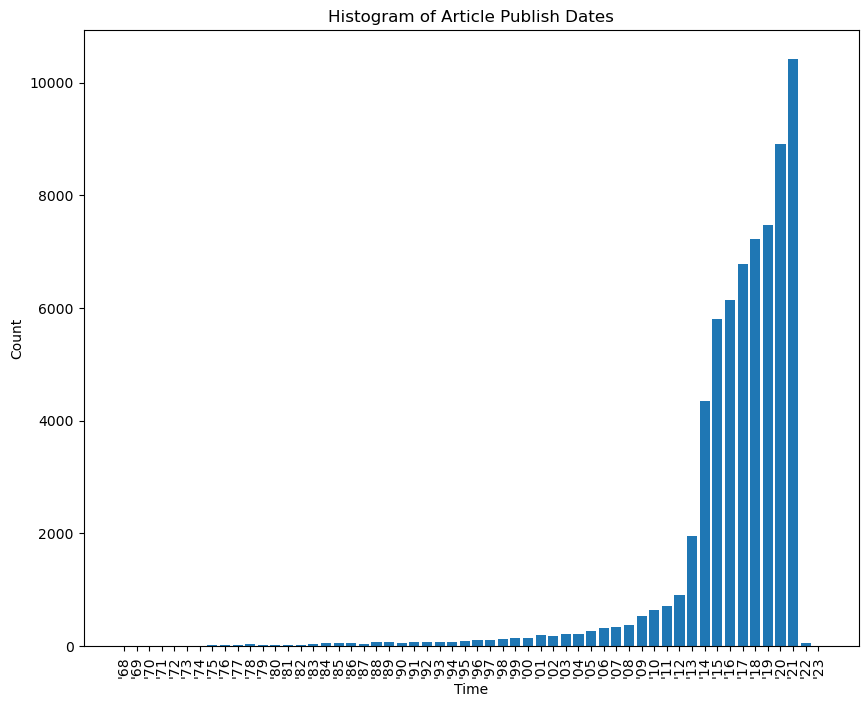

In [ ]:
plot_dates_bar(article_dates, 'Histogram of Article Publish Dates', article=True)


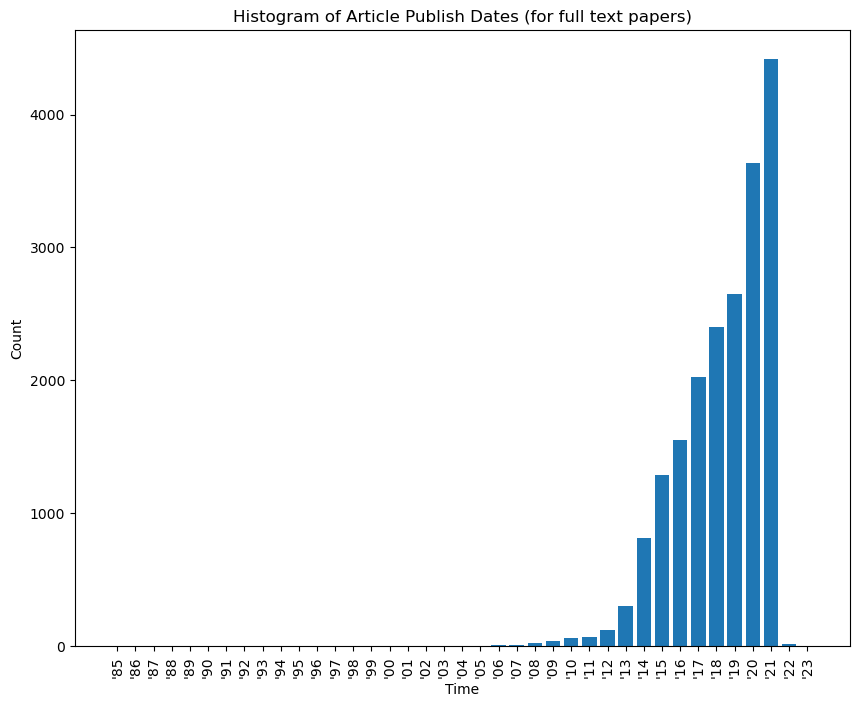

In [ ]:
article_dates_fulltext = parse_time_article([m.article.pubdate for m in matches if m.article.fulltext])
plot_dates_bar(article_dates_fulltext, 'Histogram of Article Publish Dates (for full text papers)', article=True)


## Reports per article


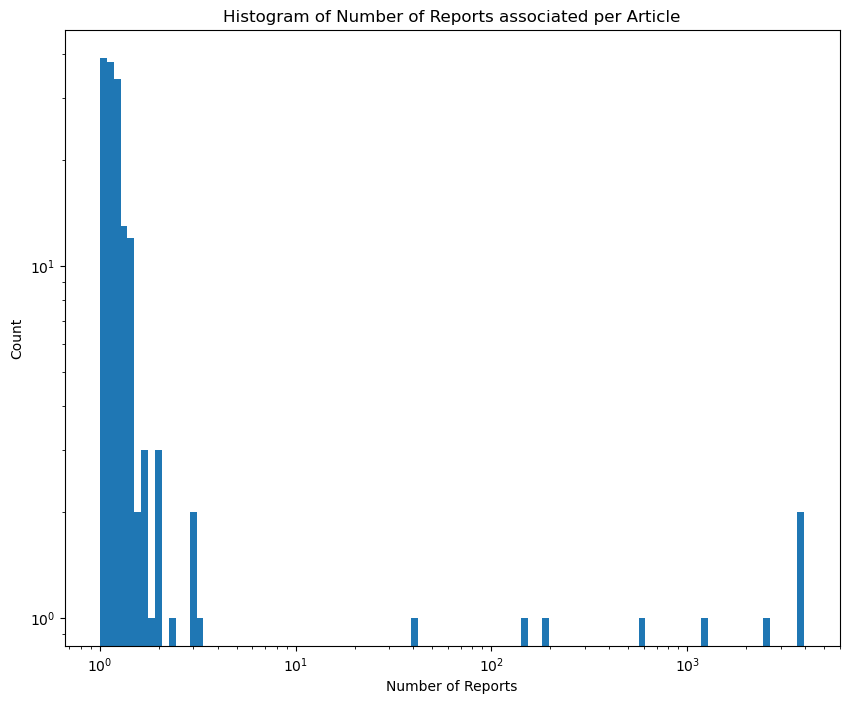

In [ ]:
import numpy as np
from collections import Counter

report_counts = Counter([len(m.reports) for m in matches])
counts, bins = np.histogram(list(report_counts.keys()), bins='auto')
log_bins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

plt.figure(figsize=(10,8))
plt.bar(log_bins[:-1], counts, width=log_bins[1:] - log_bins[:-1], align='edge')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(log_bins[:-1], [str(int(x)) for x in log_bins[:-1]], rotation=90)
plt.xlabel('Number of Reports')
plt.ylabel('Count')
plt.title('Histogram of Number of Reports associated per Article')
plt.show()

## Lengths (article and full-text)

In [ ]:
abstract_lengths = [len(m.article.abstract) for m in matches]
fulltext_lengths = [len(m.article.fulltext) for m in matches if m.article.fulltext]

In [ ]:
import matplotlib.ticker as ticker
def plot_length_histogram(lengths, title, fulltext = False):
    counts, bins = np.histogram(lengths, bins='auto')
    plt.figure(figsize=(10,8))
    plt.bar(bins[:-1], counts, width=bins[1:] - bins[:-1], align='edge')
    plt.xlabel('Length in characters')

    if fulltext:
        plt.xlim(0, 10e4)
    # plt.yscale('log')
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel('Count')
    plt.title(title)

    # Create a function to format the tick labels with comma separator
    def comma_fmt(x, pos):
        return '{:,.0f}'.format(x)

    # Set the x-axis tick formatter to the comma format function
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(comma_fmt))
    plt.show()

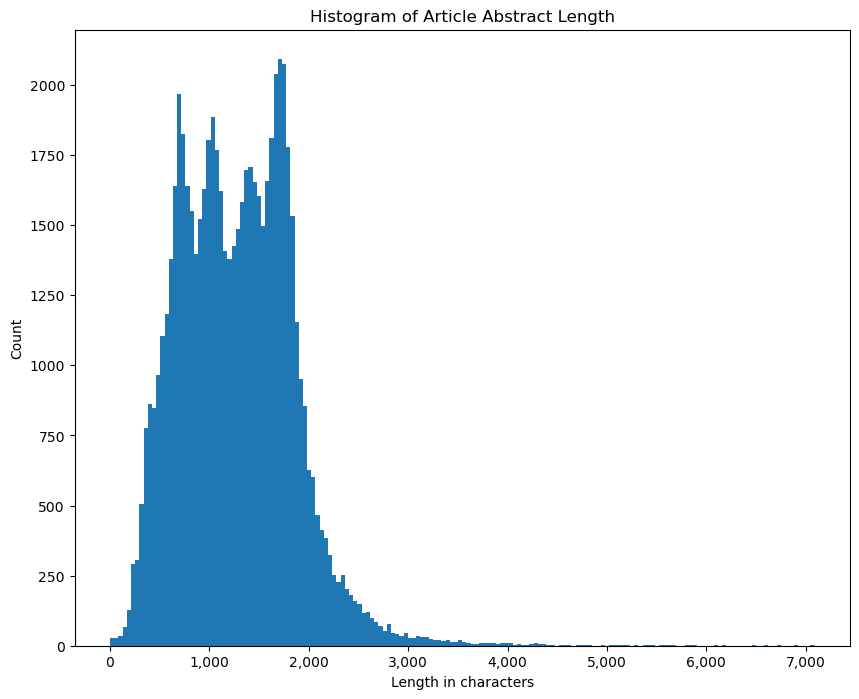

In [ ]:
plot_length_histogram(abstract_lengths, 'Histogram of Article Abstract Length')

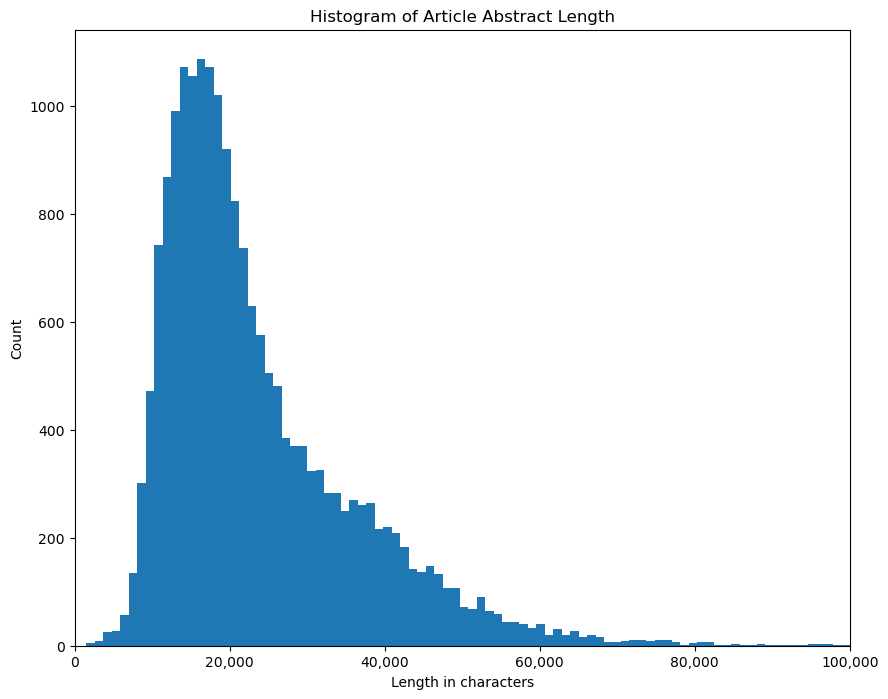

In [ ]:
plot_length_histogram(fulltext_lengths, 'Histogram of Article Abstract Length', fulltext=True)

## Keywords

In [ ]:
# todo

38842


## Check distribution of meddra versions

In [ ]:
# check all the meddra verions
versions = []
for m in matches:
    for report in m.reports:
        for reaction in report.patient.reaction:
            versions.append(reaction.reactionmeddraversionpt)

sorted_dict = dict(sorted(Counter(versions).items(), key=lambda x: x[1], reverse=True))

for key, value in sorted_dict.items():
    print(key, value)